# K-means
Загрузим библиотеки и зададим технические функции для визуализации.

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

plt.style.use(["seaborn-v0_8-darkgrid"])
plt.rcParams["figure.figsize"] = (14, 7)
plt.rcParams["font.family"] = "DejaVu Sans"

data_path = Path.cwd().parents[1] / "data"


def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)


def plot_centroids(centroids, weights=None, circle_color="w", cross_color="k"):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="o",
        s=30,
        linewidths=8,
        color=circle_color,
        zorder=10,
        alpha=0.9,
    )
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=50,
        linewidths=50,
        color=cross_color,
        zorder=11,
        alpha=1,
    )


def plot_decision_boundaries(
    clusterer,
    X,
    resolution=1000,
    show_centroids=True,
    show_xlabels=True,
    show_ylabels=True,
):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(
        np.linspace(mins[0], maxs[0], resolution),
        np.linspace(mins[1], maxs[1], resolution),
    )
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Filled Colors
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    # Contour line
    plt.contour(
        Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors="k"
    )
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)


def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(
        np.linspace(mins[0], maxs[0], resolution),
        np.linspace(mins[1], maxs[1], resolution),
    )
    # Calculate -log densities
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(
        xx,
        yy,
        Z,
        norm=LogNorm(vmin=1.0, vmax=30.0),  # normalize using log normal
        levels=np.logspace(0, 2, 12),
    )  # 12 levels
    plt.contour(
        xx,
        yy,
        Z,
        norm=LogNorm(vmin=1.0, vmax=30.0),
        levels=np.logspace(0, 2, 12),
        linewidths=1,
        colors="k",
    )

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])  # get cluster
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=2, colors="r", linestyles="dashed")

    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

## Данные

Сегодня мы будем работать с [Human Activity Recognition Using Smartphones Dataset](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Данные содержат информацию, снятую по показаниям смартфонов Samsung. 

In [2]:
X = pd.read_csv(data_path / "samsung_train_data.zip", compression="zip")
print(X.shape)
X.head()

(7352, 561)


,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913527,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943067,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996092,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


Целевой переменной является вид активности, которую выполняет человек в данный момент.

In [3]:
y = np.loadtxt(data_path / "samsung_train_labels.txt").astype(int)

X = X.values

In [4]:
X.shape

(7352, 561)

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size

[Эти лейблы соотвествуют следующим активностям:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 – walking
- 2 – walking upstairs
- 3 – walking downstairs
- 4 – sitting
- 5 – standing
- 6 – laying down

## Basic EDA

Попробуем как-то визуализировать данные. 

Данные содержат 561 компоненту. Посмотрим, что будет, если визуализировать первые две из них.

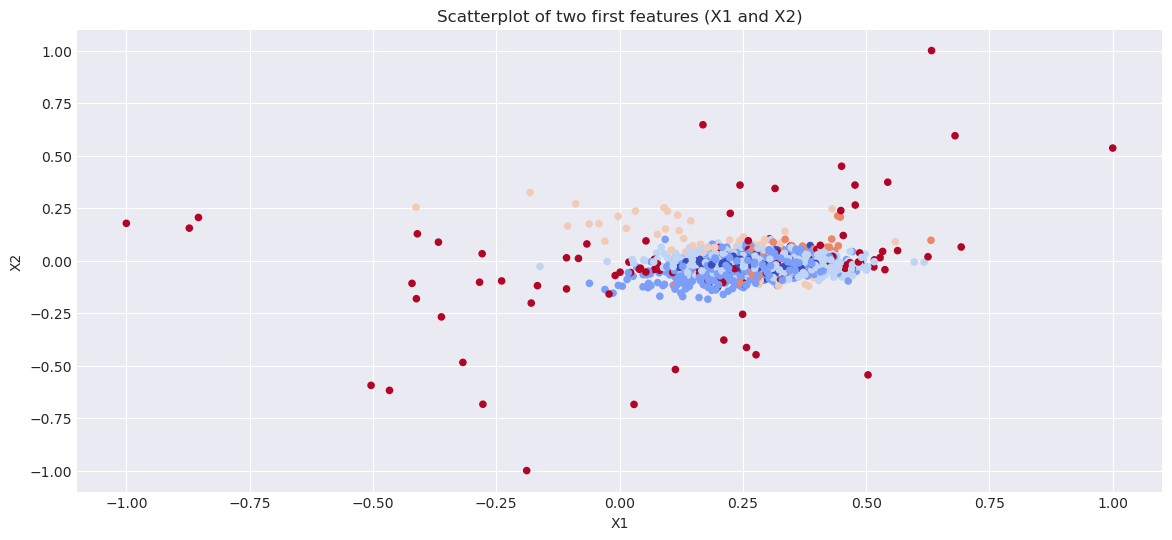

In [7]:
plt.figure(figsize=(14, 6))

plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="coolwarm")

plt.title("Scatterplot of two first features (X1 and X2)")
plt.xlabel("X1")
plt.ylabel("X2")

plt.show()

Ничего непонятно. Давайте попробуем воспользоваться PCA!

**Recap question:** кратко опишите, как устроен PCA.

Не забудем в начале нормализовать данные.

**Recap question:**  почему для PCA так важна нормализация?


In [8]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [9]:
pca = PCA()
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)

In [10]:
X_pca.shape

(7352, 561)

### Визуализация PCA

Давайте сравним, как изменилась картина после применения PCA.

Еще раз вспомним, как выглядели исходные данные.

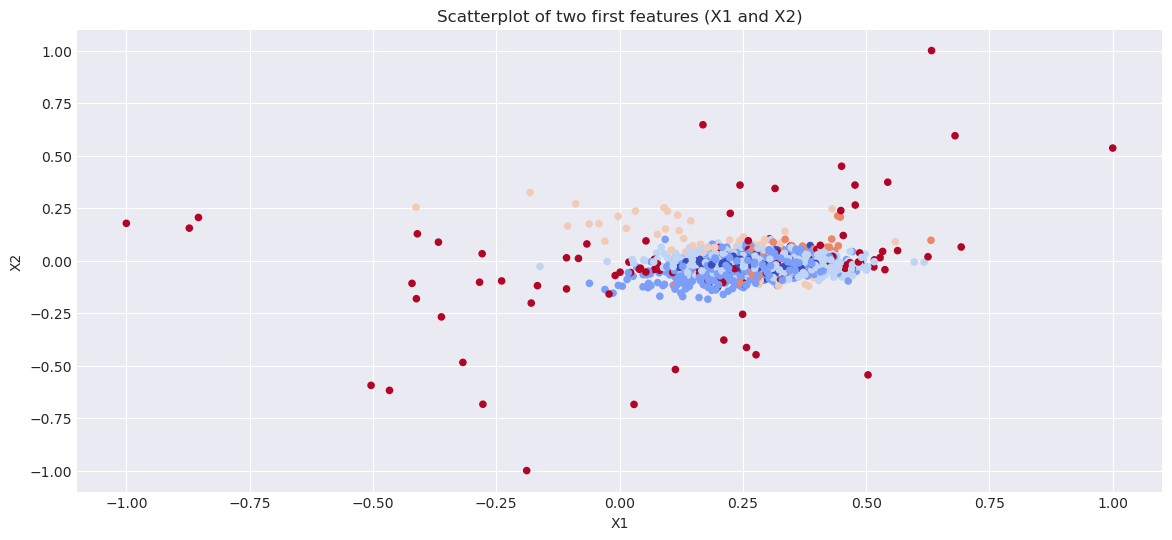

In [11]:
plt.figure(figsize=(14, 6))

plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="coolwarm")

plt.title("Scatterplot of two first features (X1 and X2)")
plt.xlabel("X1")
plt.ylabel("X2")

plt.show()

А теперь визуализируем, как они выглядят после PCA.

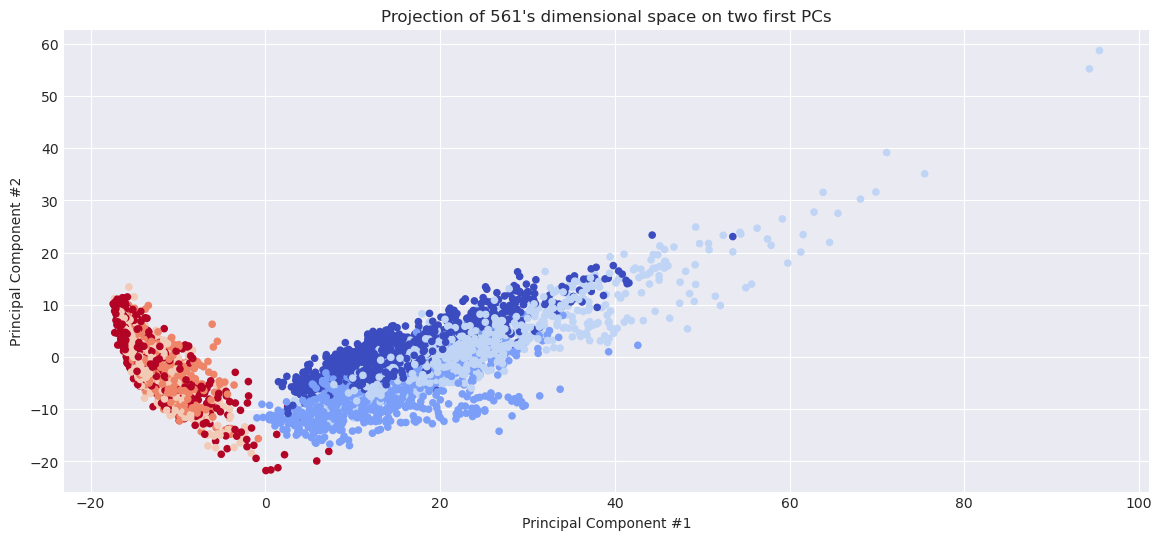

In [12]:
plt.figure(figsize=(14, 6))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap="coolwarm")

plt.title("Projection of 561's dimensional space on two first PCs")
plt.xlabel("Principal Component #1")
plt.ylabel("Principal Component #2")

plt.show()

Кажется, отличный результат. Давайте для решения задачи кластеризации перейдем к главным компонентам. Для удобства визуализации возьмем первык 2 (главные) компоненты.

In [13]:
X_two_dim = X_pca[:, :2]

idx = (X_two_dim[:, 0] < 50) & (X_two_dim[:, 1] < 15)

X_two_dim = X_two_dim  # [idx,:]

### Визуализация t-SNE

Проведем также сравнение с результатами визуализации с помощью t-SNE.

In [14]:
import warnings

warnings.filterwarnings("ignore")

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_scaled)

X_tsne.shape

(7352, 2)

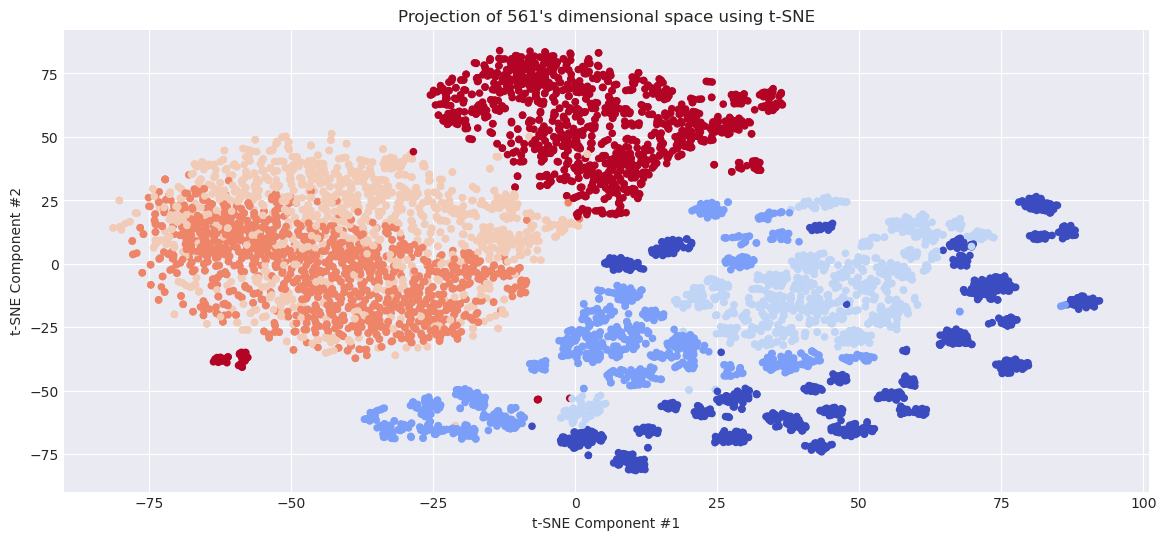

In [16]:
plt.figure(figsize=(14, 6))

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=20, cmap="coolwarm")

plt.title("Projection of 561's dimensional space using t-SNE")
plt.xlabel("t-SNE Component #1")
plt.ylabel("t-SNE Component #2")

plt.show()

### Визуализация UMAP

Проведем сравнение с результатами визуализации с помощью UMAP.

In [17]:
import umap

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_scaled)

X_umap.shape

(7352, 2)

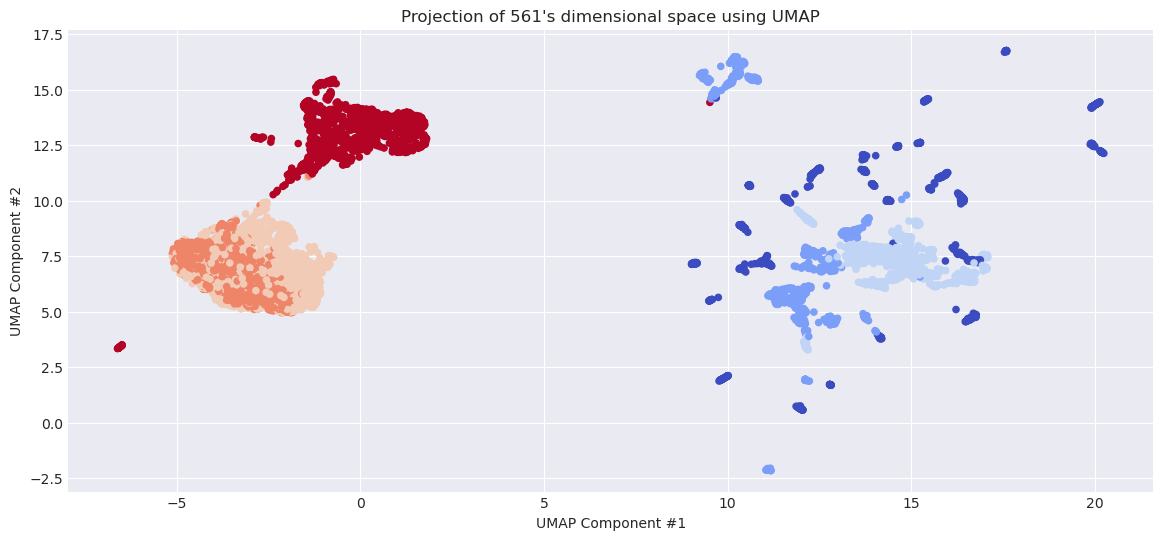

In [18]:
plt.figure(figsize=(14, 6))

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, s=20, cmap="coolwarm")

plt.title("Projection of 561's dimensional space using UMAP")
plt.xlabel("UMAP Component #1")
plt.ylabel("UMAP Component #2")

plt.show()

## Кластеризация

Интуитивная постановка задачи кластеризации довольно проста и представляет из себя наше желание сказать: "Вот тут у меня насыпаны точки. Я вижу, что они сваливаются в какие-то кучки вместе. Было бы круто иметь возможность эти точки относить к кучкам и в случае появления новой точки на плоскости говорить, в какую кучку она падает." Из такой постановки видно, что пространства для фантазии получается много, и от этого возникает соответствующее множество алгоритмов решения этой задачи.

Формално, **кластеризация** — задача группировки множества объектов на подмножества (кластеры) таким образом, чтобы объекты из одного кластера были более похожи друг на друга, чем на объекты из других кластеров по какому-либо критерию.

Задача кластеризации относится к классу задач обучения без учителя.

### k-Means

Алгоритм **K-means** (он же К-средних), наверное, самый популярный и простой алгоритм кластеризации и очень легко представляется в виде простого псевдокода:


    1) Выбрать количество кластеров k, которое нам кажется оптимальным для наших данных.

    2) Высыпать случайным образом в пространство наших данных k точек (центроидов).

    3) Для каждой точки нашего набора данных посчитать, к какому центроиду она ближе.

    4) Переместить каждый центроид в центр выборки, которую мы отнесли к этому центроиду.

    5) Повторять последние два шага фиксированное число раз, либо до тех пор пока центроиды не "сойдутся" (обычно это значит, что их смещение относительно предыдущего положения не превышает какого-то заранее заданного небольшого значения).

# Sklearn implementation

В качестве дефолтного baseline обучим самый простой kmeans с кластеризацией на 2 кластера.

In [19]:
kmeans = KMeans(n_clusters=2)

kmeans.fit(X_two_dim)

KMeans(n_clusters=2)

Посмотрим, как выглядят получившиеся кластера.


In [20]:
kmeans.labels_

array([0, 0, 0, ..., 1, 1, 1])

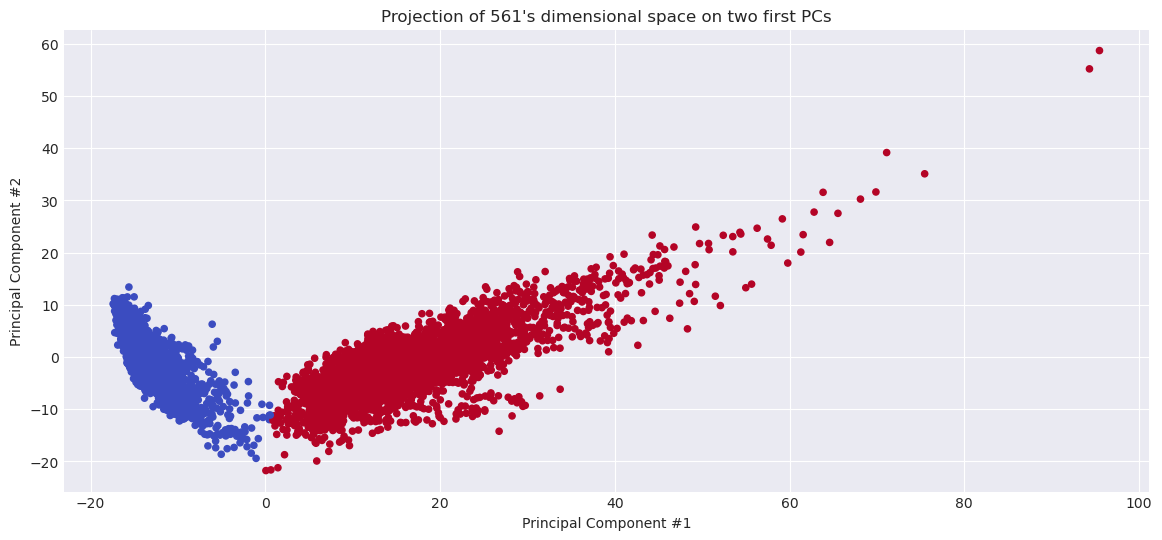

In [21]:
plt.figure(figsize=(14, 6))

plt.scatter(X_two_dim[:, 0], X_two_dim[:, 1], c=kmeans.labels_, s=20, cmap="coolwarm")

plt.title("Projection of 561's dimensional space on two first PCs")
plt.xlabel("Principal Component #1")
plt.ylabel("Principal Component #2")

plt.show()

Визуализируем центроиды и разделяющие классы гиперплоскость.


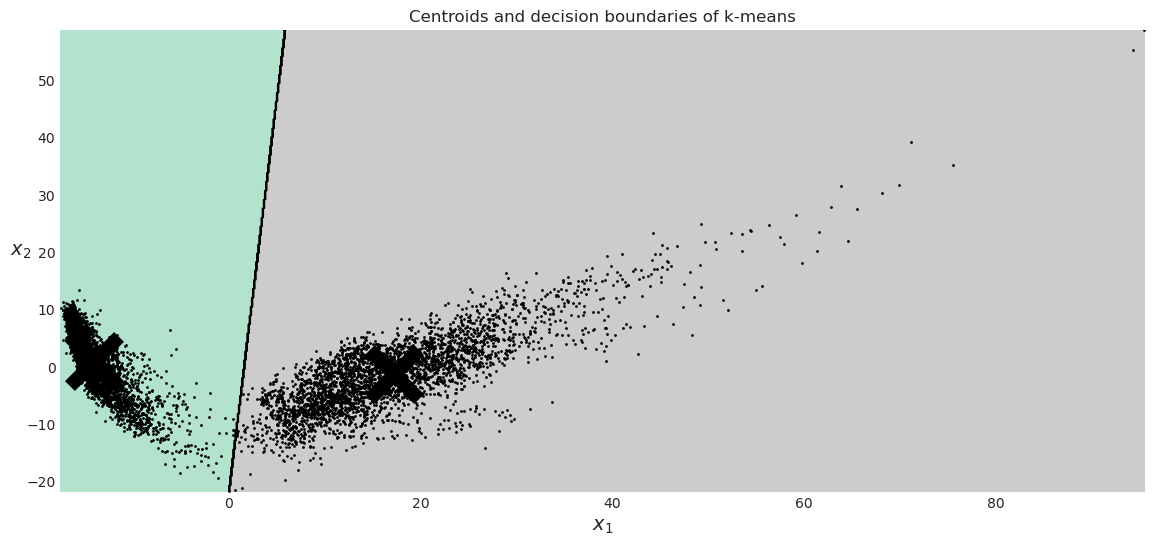

In [22]:
plt.figure(figsize=(14, 6))
plot_decision_boundaries(kmeans, X_two_dim)

plt.title("Centroids and decision boundaries of k-means")

plt.show()

Также можем получить предсказания для отдельной точки.

In [23]:
X_two_dim[:1, :]

array([[-16.13854357,   2.15202398]])

In [24]:
kmeans.predict([[-16, 2]])

array([0])

In [25]:
a = kmeans.transform(X_two_dim[:1, :])

print(a)

[[ 2.44297949 33.55780269]]


In [26]:
np.argmin(a)

0

# Выбор числа кластеров

Не всегда есть возможность визуализировать датасет, поэтому давайте попробуем выбрать число кластеров  $k$ автоматически с помощью метода локтя.

Посчитаем индекс инерции для kmeans с числом кластеров в диапазоне он 1 до 10.

In [27]:
k_max = 10

inertia = []
for k in range(1, k_max):
    kmeans = KMeans(n_clusters=k).fit(X_two_dim)
    inertia.append(np.sqrt(kmeans.inertia_))

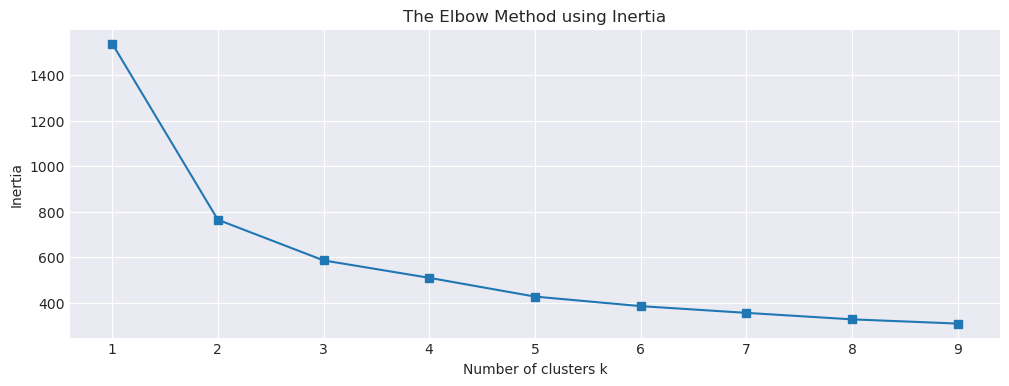

In [28]:
plt.figure(figsize=(12, 4))
plt.plot(range(1, k_max), inertia, marker="s")

plt.title("The Elbow Method using Inertia")
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia")

plt.show()

In [29]:
d = {}
for k in range(2, k_max - 1):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])


Для определния оптимального числа кластеров необходимо выбрать число  на "локте" - такую точку, после которой индекс инерции начинает убывать "in a linear fashion".


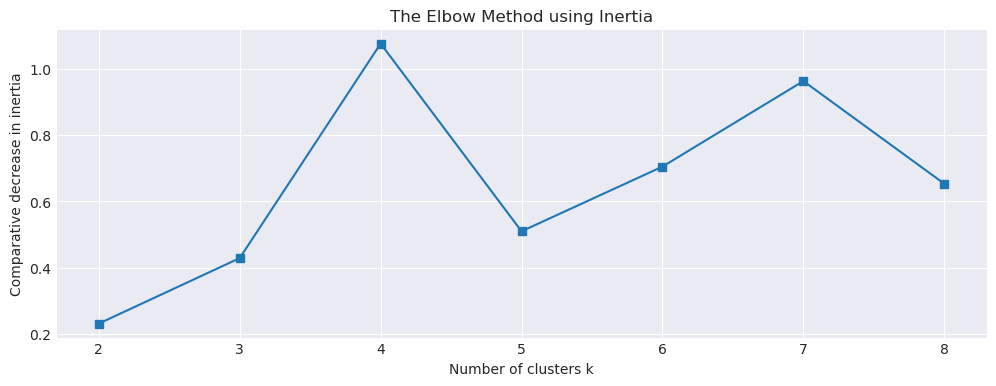

In [30]:
plt.figure(figsize=(12, 4))
plt.plot(range(2, k_max - 1), [x for x in d.values()], marker="s")

plt.title("The Elbow Method using Inertia")
plt.xlabel("Number of clusters k")
plt.ylabel("Comparative decrease in inertia")

plt.show()

In [31]:
kmeans = KMeans(n_clusters=2)

kmeans.fit(X_two_dim)

KMeans(n_clusters=2)

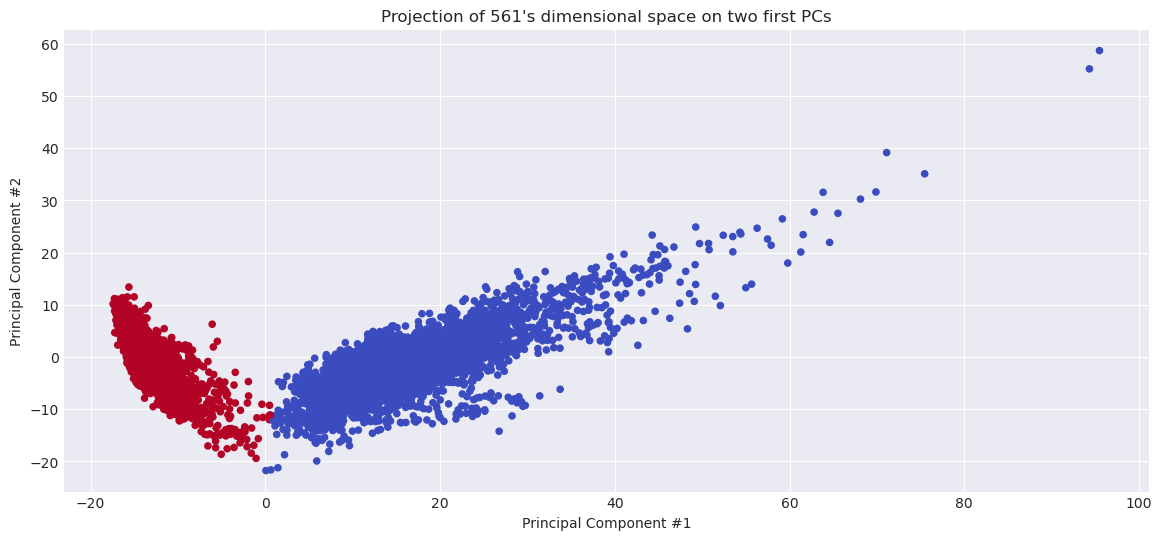

In [32]:
plt.figure(figsize=(14, 6))

plt.scatter(X_two_dim[:, 0], X_two_dim[:, 1], c=kmeans.labels_, s=20, cmap="coolwarm")

plt.title("Projection of 561's dimensional space on two first PCs")
plt.xlabel("Principal Component #1")
plt.ylabel("Principal Component #2")

plt.show()

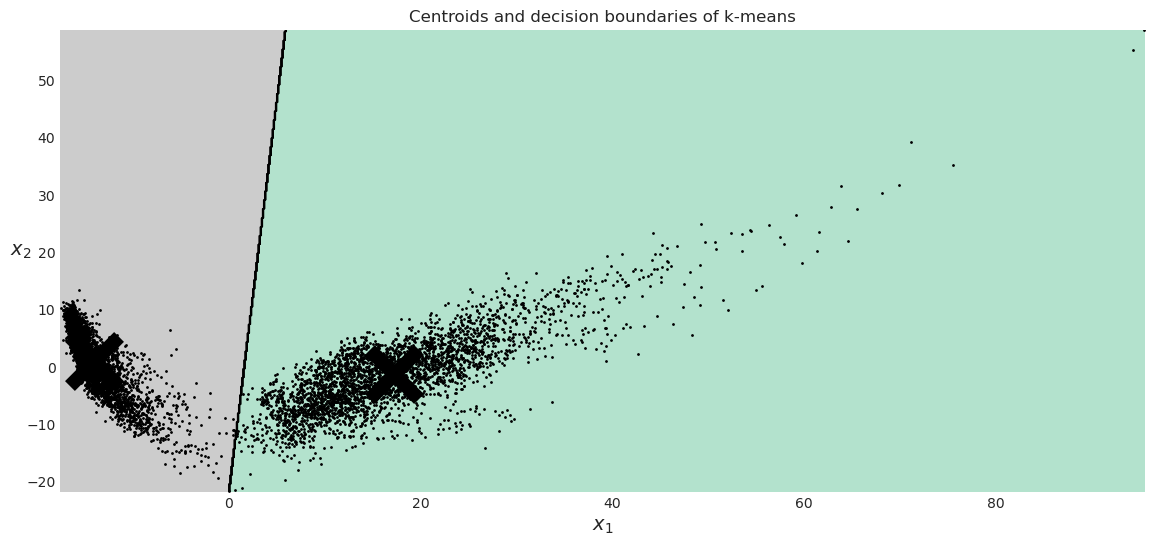

In [33]:
plt.figure(figsize=(14, 6))
plot_decision_boundaries(kmeans, X_two_dim)

plt.title("Centroids and decision boundaries of k-means")

plt.show()

### Выбор оптимального числа кластеров, для компонент, обеспечивающих 95% изменчивости данных

In [34]:
explained_variance_ratio = pca.explained_variance_ratio_

cumsum = np.cumsum(explained_variance_ratio)
d = np.argmax(cumsum >= 0.95) + 1
d

102

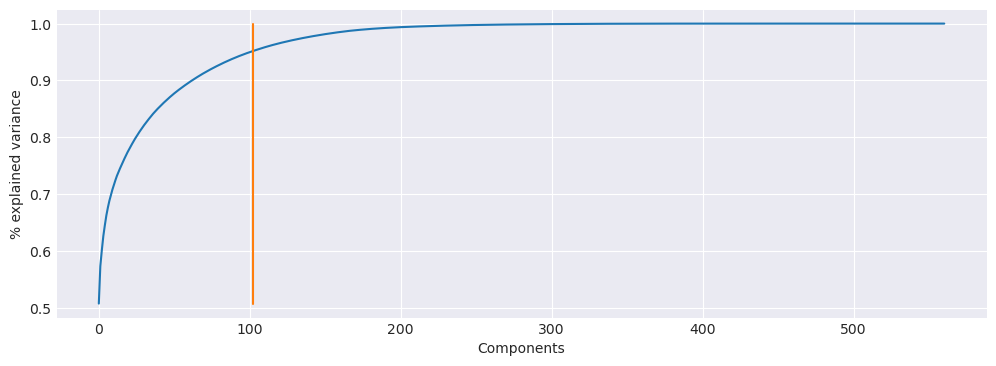

In [35]:
plt.figure(figsize=(12, 4))
plt.plot(cumsum)
plt.plot([d, d], [cumsum.min(), 1])
plt.xlabel("Components")
plt.ylabel("% explained variance")
plt.show()

Посчитаем индекс инерции для kmeans с числом кластеров в диапазоне он 1 до 10.

In [36]:
X_95 = X_pca[:, :d]

inertia = []
for k in range(1, k_max):
    kmeans = KMeans(n_clusters=k).fit(X_95)
    inertia.append(np.sqrt(kmeans.inertia_))

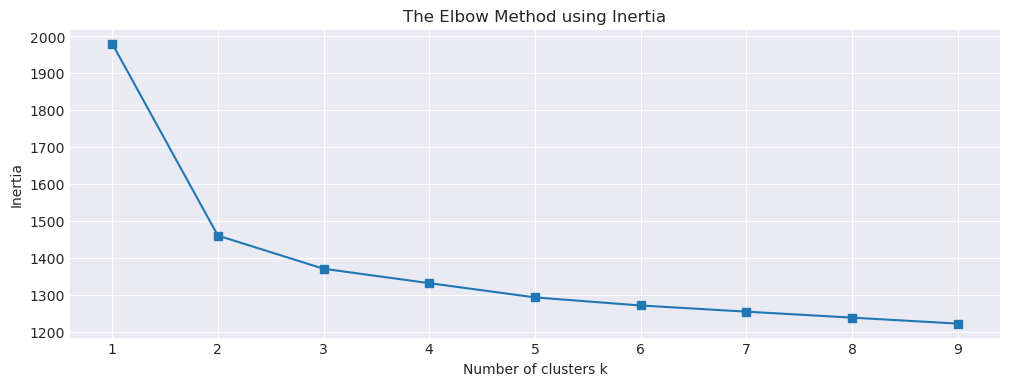

In [37]:
plt.figure(figsize=(12, 4))
plt.plot(range(1, k_max), inertia, marker="s")

plt.title("The Elbow Method using Inertia")
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia")

plt.show()

Для определния оптимального числа кластеров необходимо выбрать число  на "локте" - такую точку, после которой индекс инерции начинает убывать "in a linear fashion".

In [38]:
d = {}
for k in range(2, k_max - 1):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])

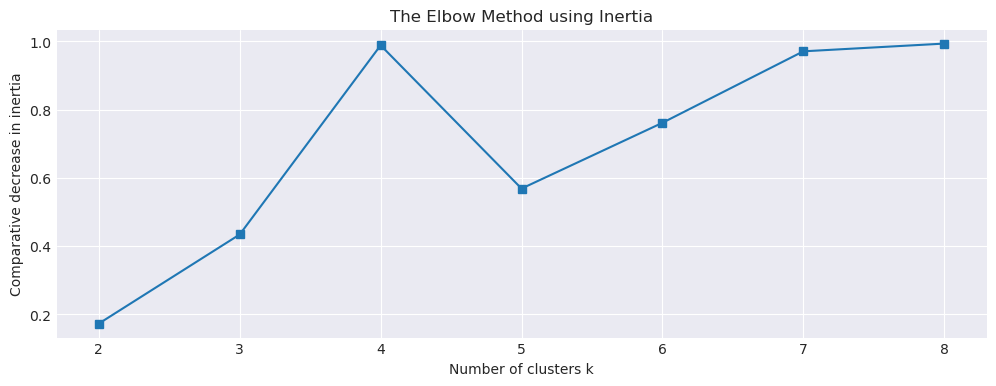

In [39]:
plt.figure(figsize=(12, 4))
plt.plot(range(2, k_max - 1), [x for x in d.values()], marker="s")

plt.title("The Elbow Method using Inertia")
plt.xlabel("Number of clusters k")
plt.ylabel("Comparative decrease in inertia")

plt.show()

In [40]:
kmeans = KMeans(n_clusters=2)

kmeans.fit(X_two_dim)

KMeans(n_clusters=2)

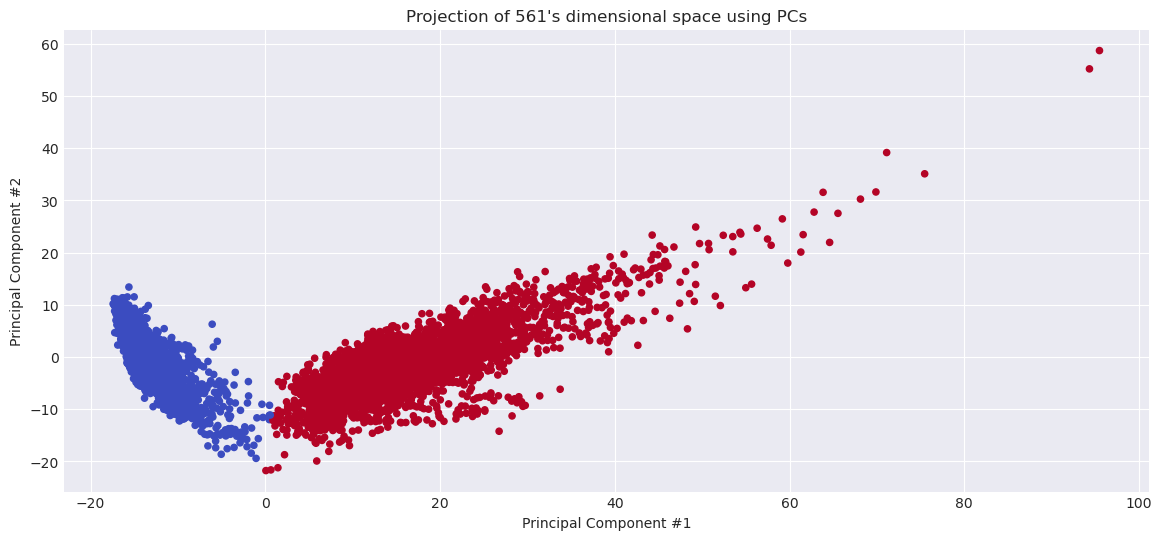

In [41]:
plt.figure(figsize=(14, 6))

plt.scatter(X_95[:, 0], X_95[:, 1], c=kmeans.labels_, s=20, cmap="coolwarm")

plt.title("Projection of 561's dimensional space using PCs")
plt.xlabel("Principal Component #1")
plt.ylabel("Principal Component #2")

plt.show()